In [18]:
import pandas as pd
import psycopg2 as pg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score
import optuna
import pickle
from sklearn.feature_selection import SequentialFeatureSelector
reload = False
def norm(x):
    if len(x)==1 and x[0]=='':
        return []
    else:
        return x
if reload:
    engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
    df = pd.read_sql('select * from data_safeidx', con=engine)
    with open('data.pkl','wb') as f:
        pickle.dump(df,f)
else:
    with open('data.pkl','rb') as f:
        df = pickle.load(f)
    #df = pd.read_csv('pid.csv').drop(columns='Unnamed: 0')
    #df.evacuation_vehicles =  df.evacuation_vehicles.apply(lambda x:norm(x.replace(' ','').replace('[','').replace(']','').split(',')))

In [4]:
df.head()

difficulty             cause     town province gender equipment helmet  \
0     novice        fall_alone   SIKLOS               F       ski   None   
1   advanced        fall_alone    MALMO               M       ski   None   
2   advanced        fall_alone  CALDARO       BZ      F       ski   None   
3   advanced  collision_person     LINZ               M       ski   None   
4   advanced  collision_person   RUSAVA               M       ski   None   

               destination   diagnosis india   age          country  \
0  hospital_emergency_room  distortion  None  32.0         Ungheria   
1  hospital_emergency_room      bruise  None  32.0           Svezia   
2                 domicile       other  None  12.0           Italia   
3  hospital_emergency_room      bruise  None  58.0          Austria   
4                    other      bruise  None  25.0  Repubblica Ceca   

  injury_side injury_general_location evacuation_vehicles  
0           L             lower_limbs              [akja]  
1           R           skull_or_face              [akja]  
2           R                    None        [snowmobile]  
3           R             lower_limbs        [snowmobile]  
4           L             lower_limbs             [other]

In [5]:

ev = set({})
for i,row in df.iterrows():
    ev = ev.union(set(row.evacuation_vehicles))
for c in ev:
    df[c] = False
for i,row in df.iterrows():
    for c in row.evacuation_vehicles:
        df.loc[i,c] = True
df.drop(columns=['town','province','evacuation_vehicles'],inplace=True)



In [6]:
df.columns

Index(['difficulty', 'cause', 'gender', 'equipment', 'helmet', 'destination',
       'diagnosis', 'india', 'age', 'country', 'injury_side',
       'injury_general_location', 'akja', 'snowmobile_sled', 'indipendently',
       'quad', 'car', 'ambulance', 'offroad_vehicle', 'ski_lift', 'other',
       'helicopter', 'skiarea_ambulance', 'snowmobile', 'privat_helicopter'],
      dtype='object')

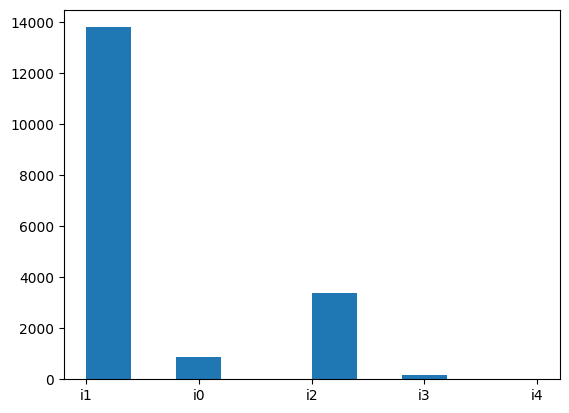

In [7]:
labeled = df[~pd.isna(df.india)].reset_index().drop(columns='index')
labeled['age'] =  labeled['age'].astype(np.float32).fillna(np.nan)
plt.hist(labeled.india);

/tmp/ipykernel_7203/4107850114.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


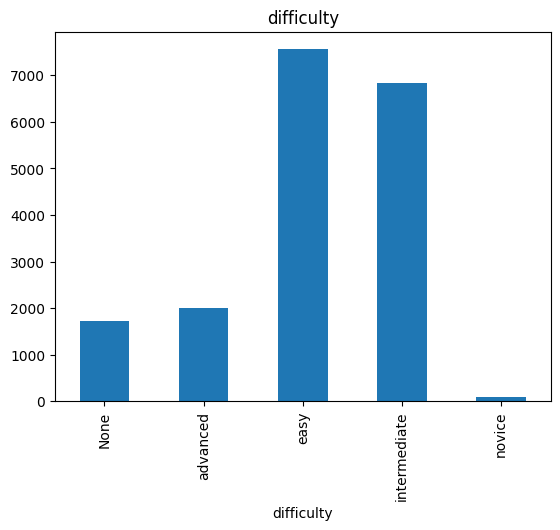

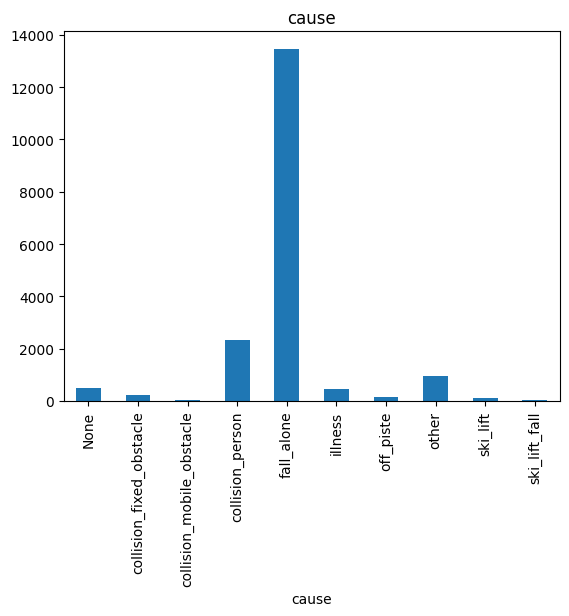

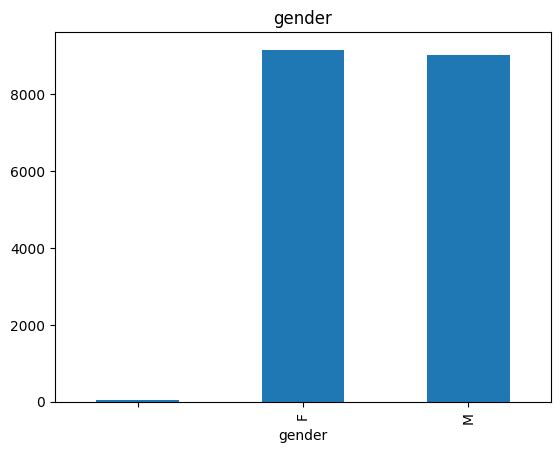

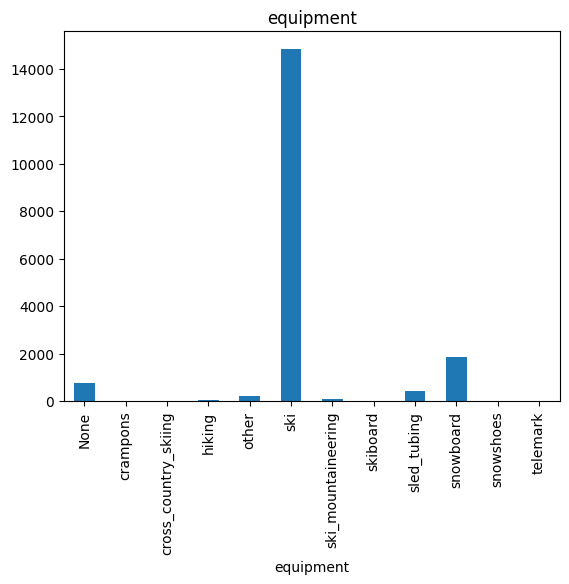

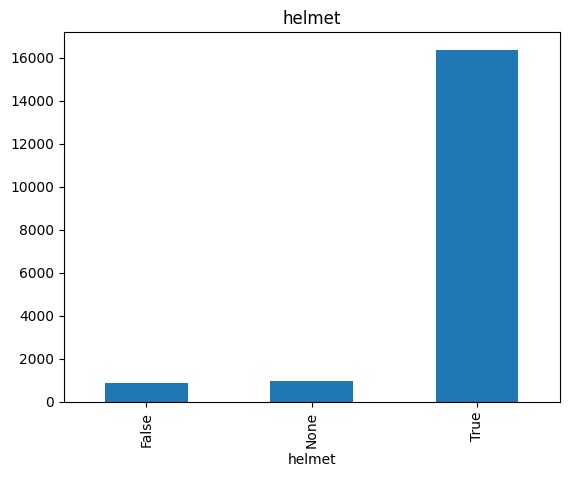

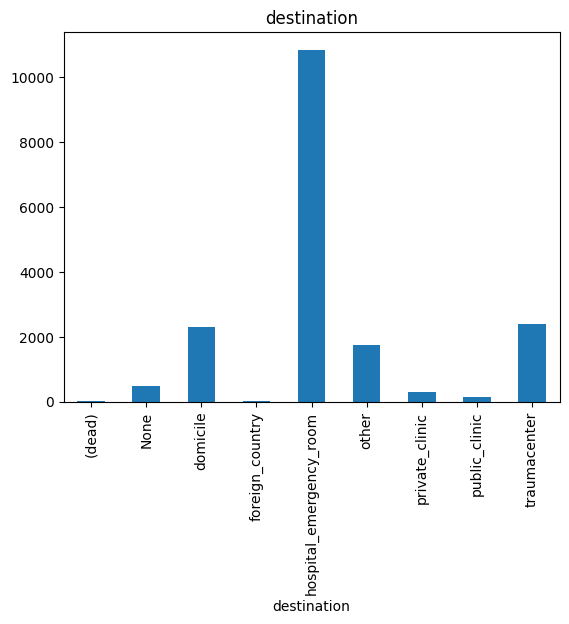

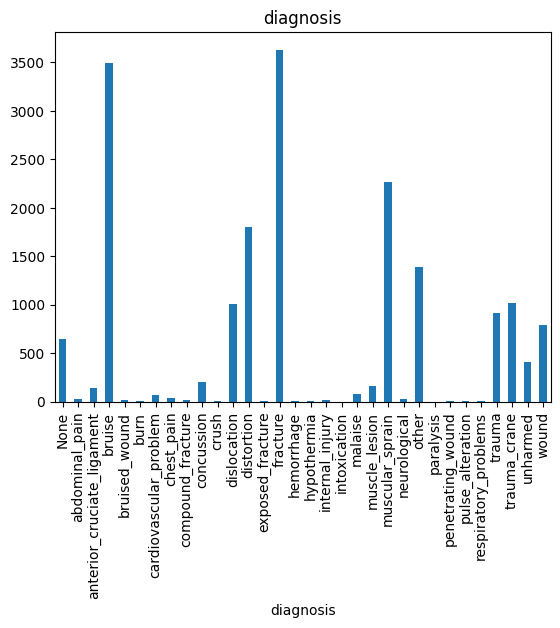

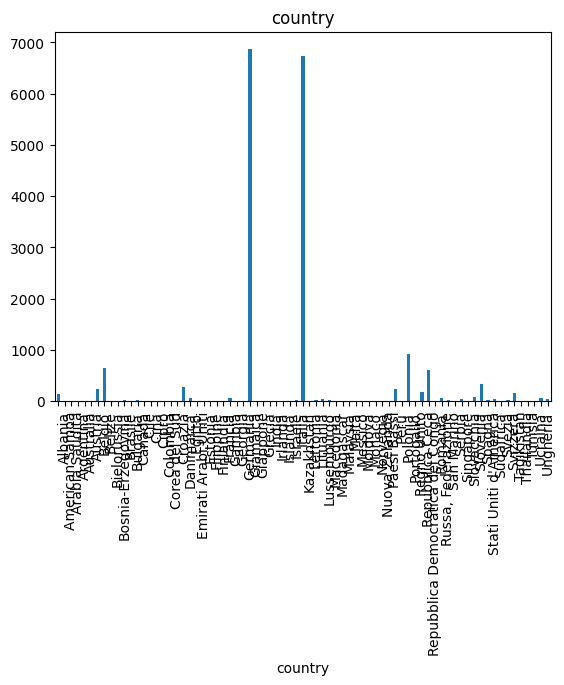

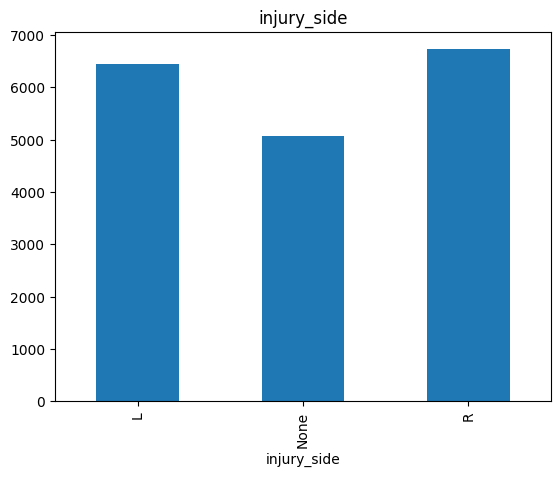

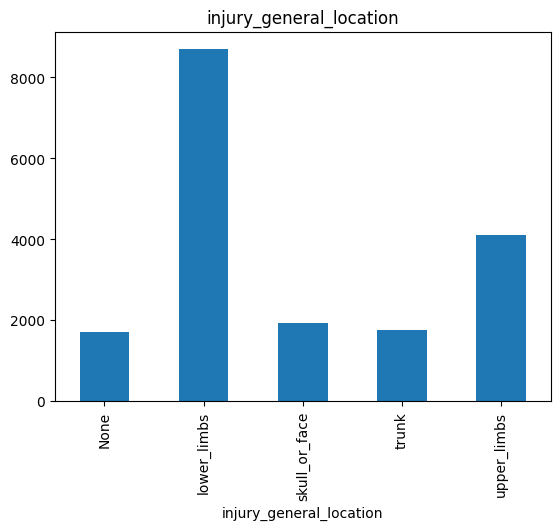

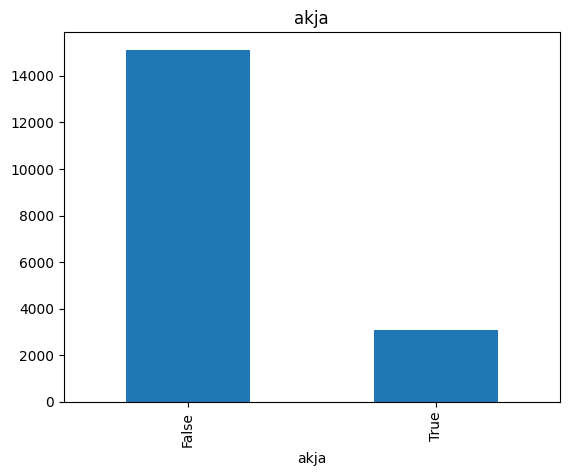

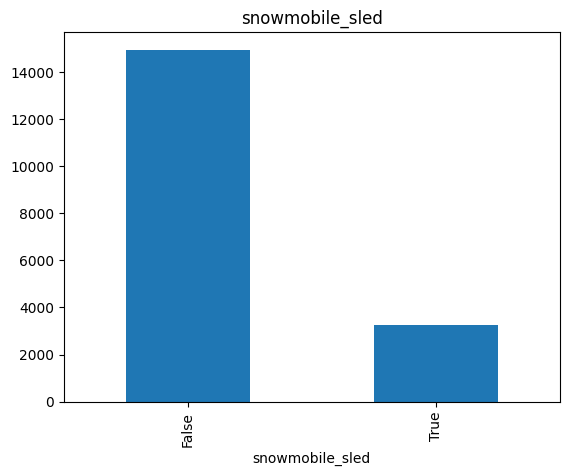

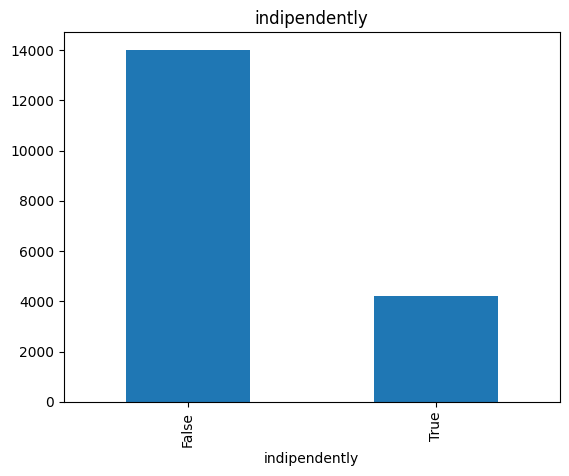

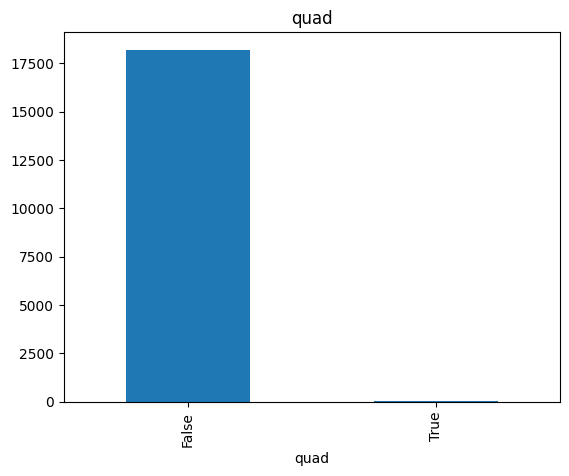

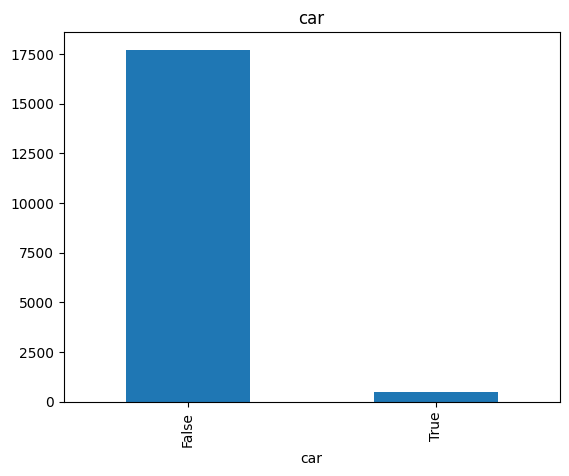

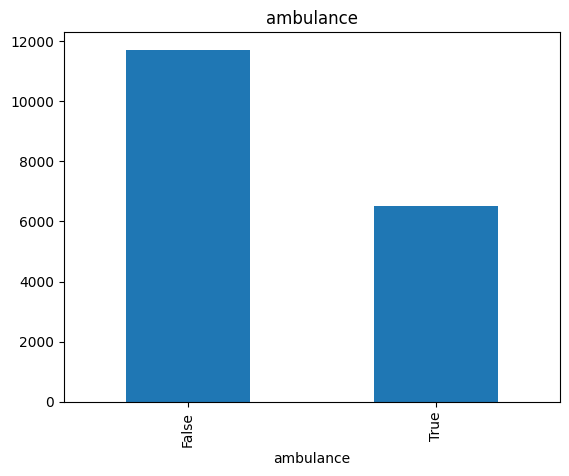

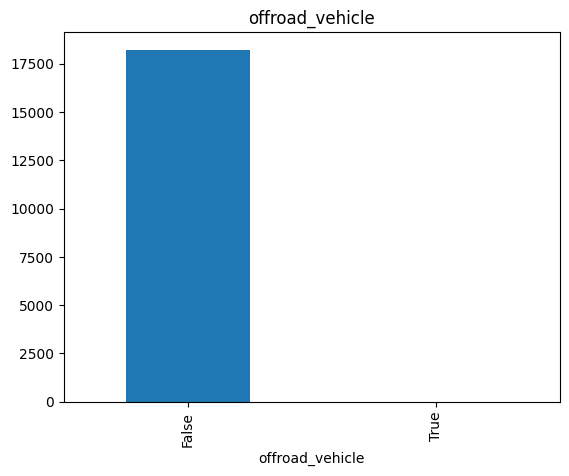

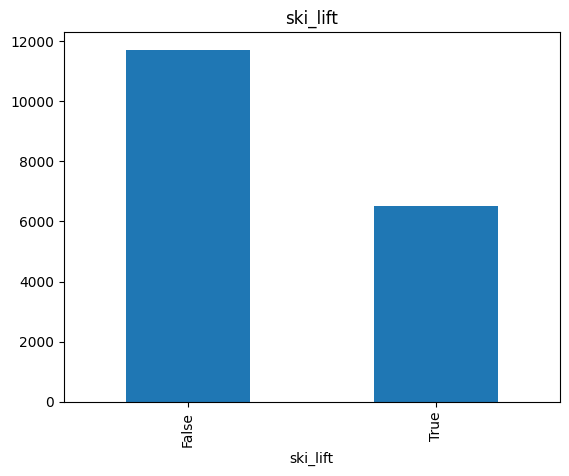

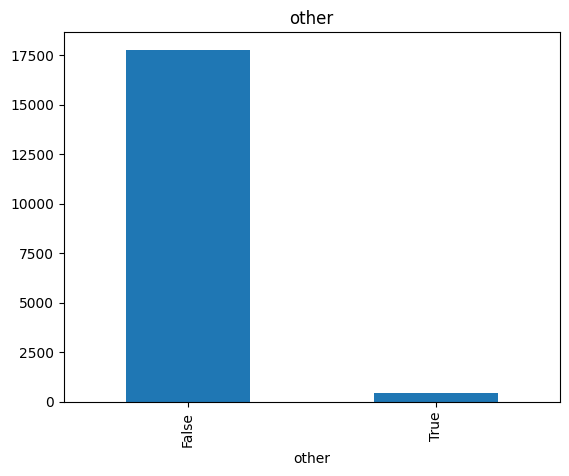

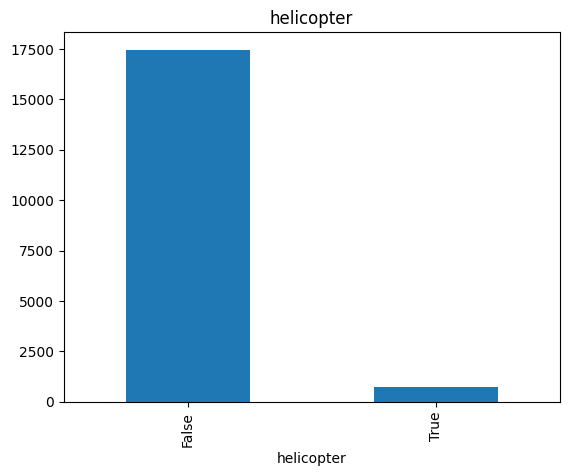

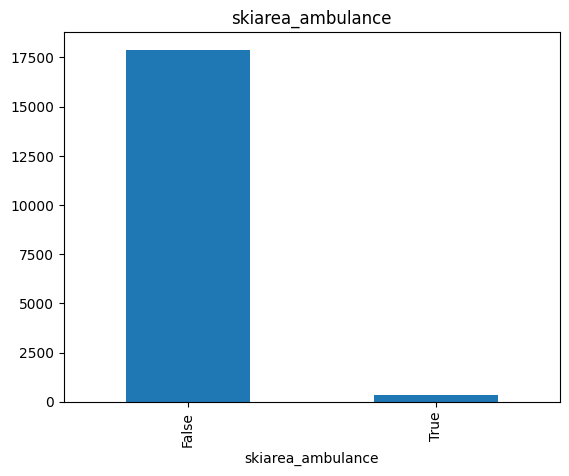

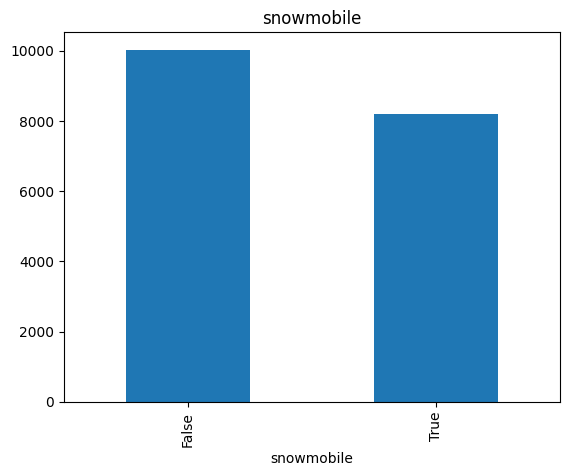

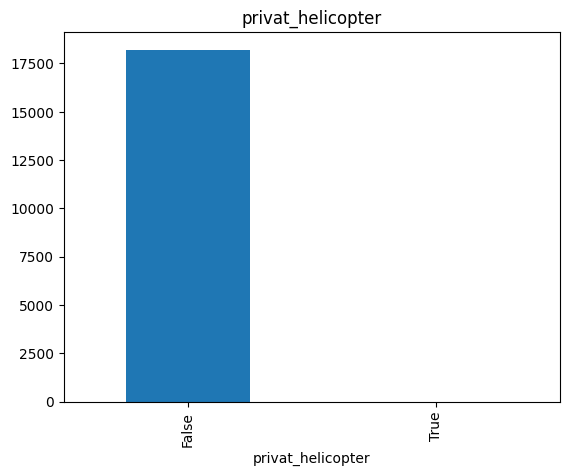

In [8]:
## plot of categorical variables, there are some under-represented categories, 
## maybe it is possible to obtain a more stable model removing such classes
to_remove = {}
TH = 0.5
for c in labeled.columns:
    if c not in ['india','age']:
        labeled[c] = labeled[c].astype('str')  
        plt.figure()
        labeled.groupby(c)[c].count().plot(kind='bar')
        plt.title(c)
        tmp = labeled.groupby(c)[c].count()
        tmp = 100*tmp/tmp.max()
        tmp = tmp[tmp<TH]
        if len(tmp)>0:
            for k in tmp.index:
                if c not in to_remove.keys():
                    to_remove[c]= []
                to_remove[c].append(k)

In [9]:
labeled_small = labeled.copy()
for c in to_remove.keys():
    for k in to_remove[c]:
        labeled_small.loc[labeled_small[c]==k,c] = 'other'
for c in labeled_small.columns:
    if c!='age':
        labeled_small[c] =  labeled_small[c].fillna('None').astype('category')  
        labeled[c] =  labeled[c].fillna('None').astype('category')
labeled.dropna(inplace=True)
labeled_small.dropna(inplace=True)

/tmp/ipykernel_7203/1258876718.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_7203/1258876718.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_7203/1258876718.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_7

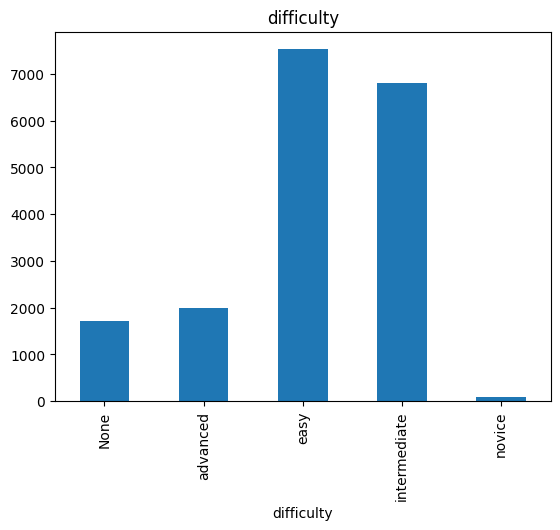

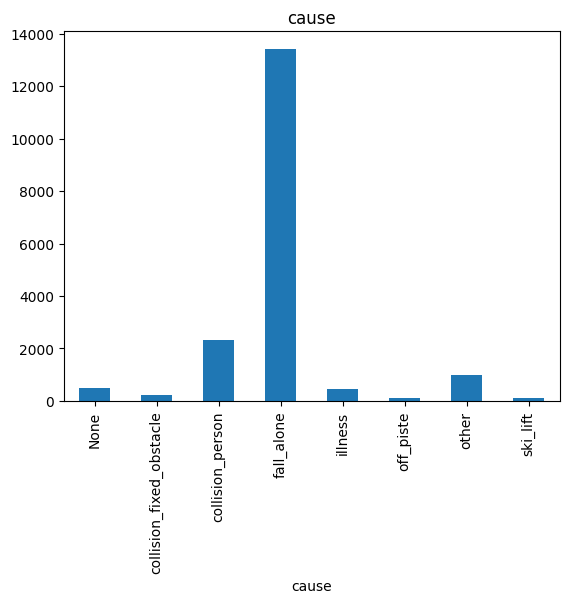

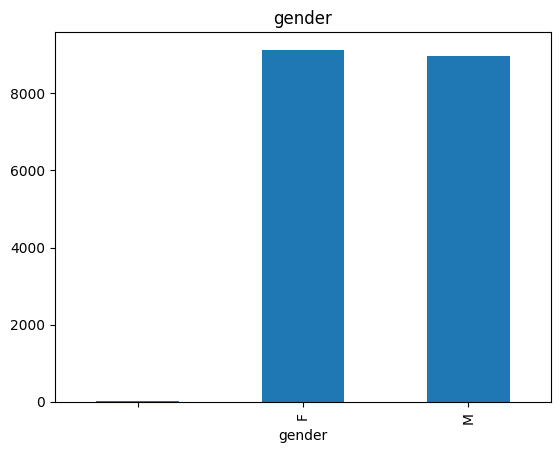

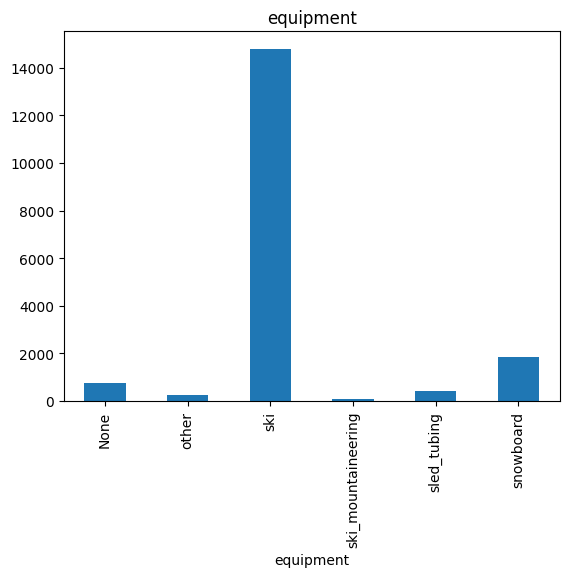

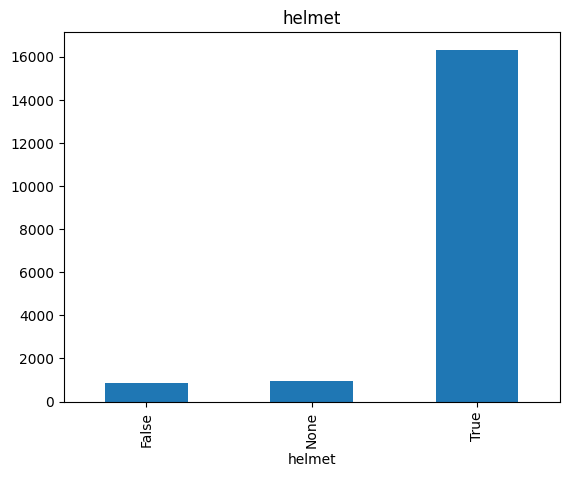

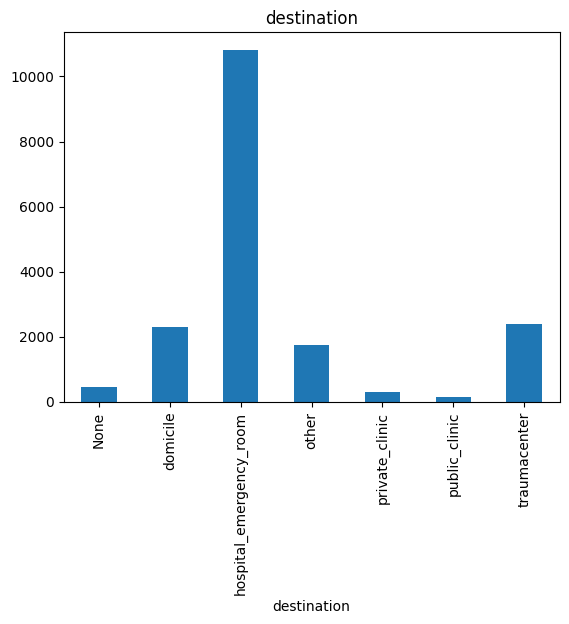

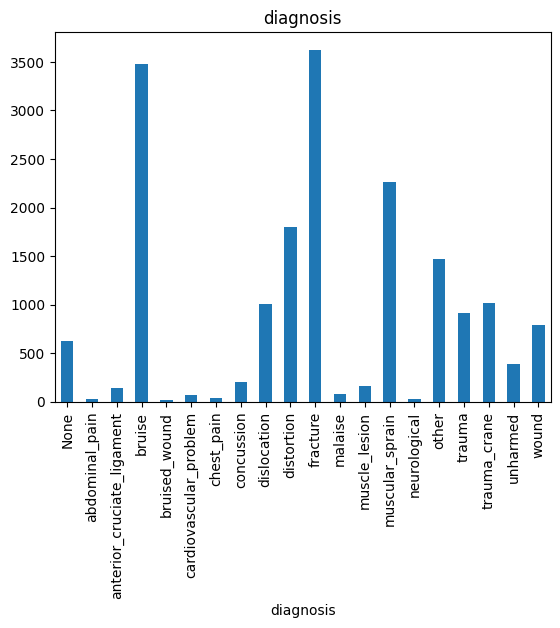

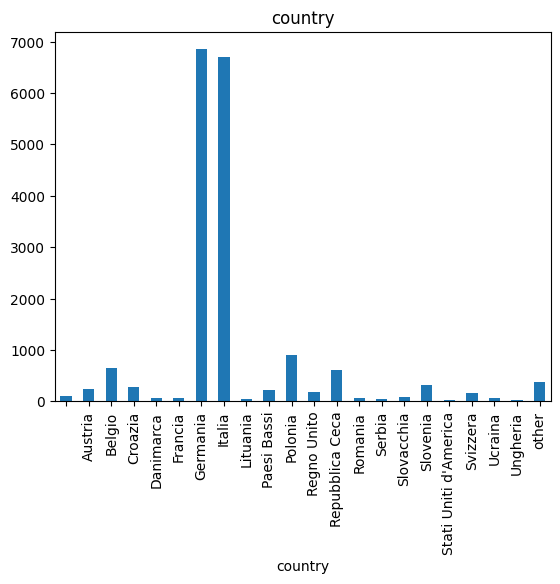

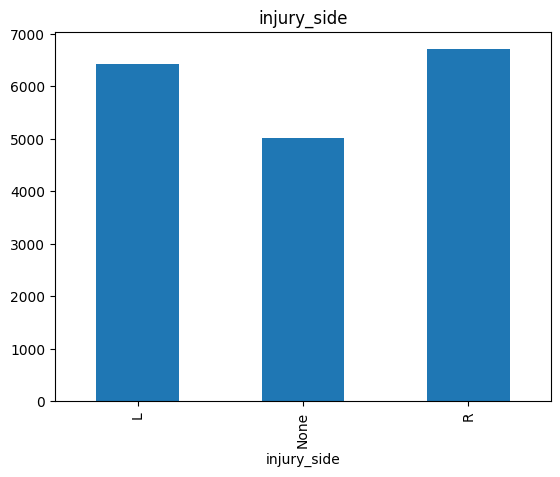

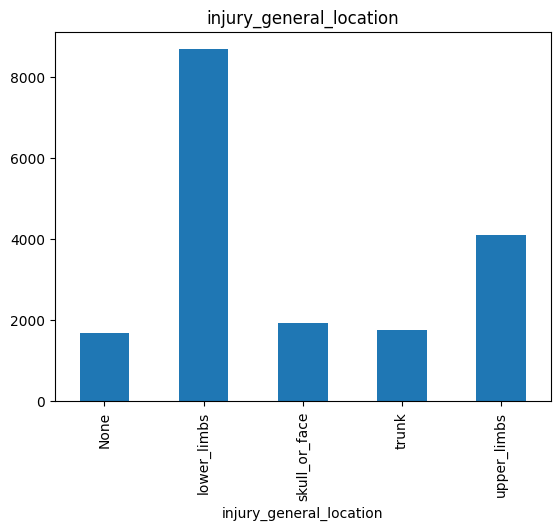

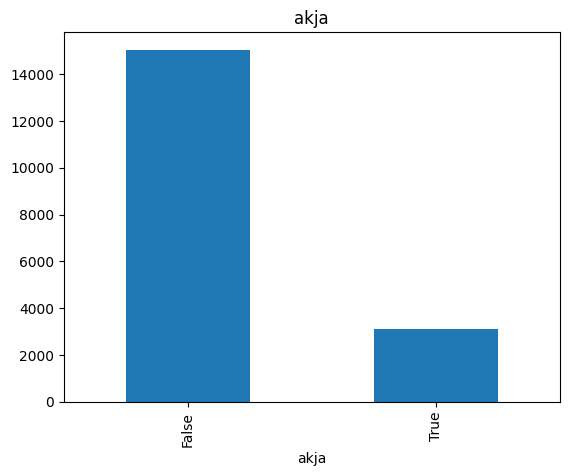

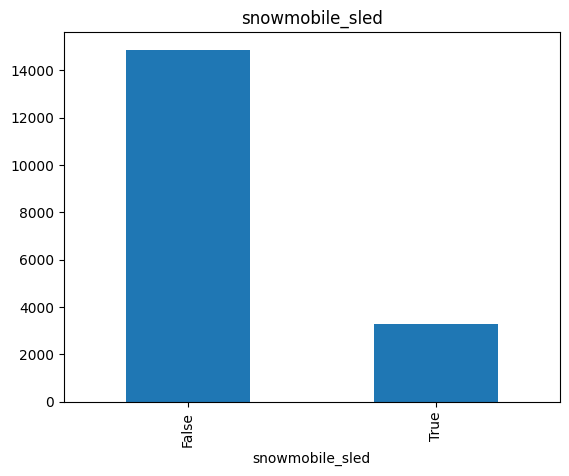

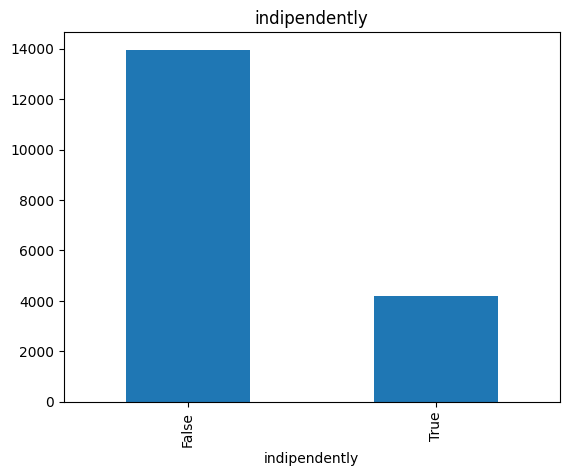

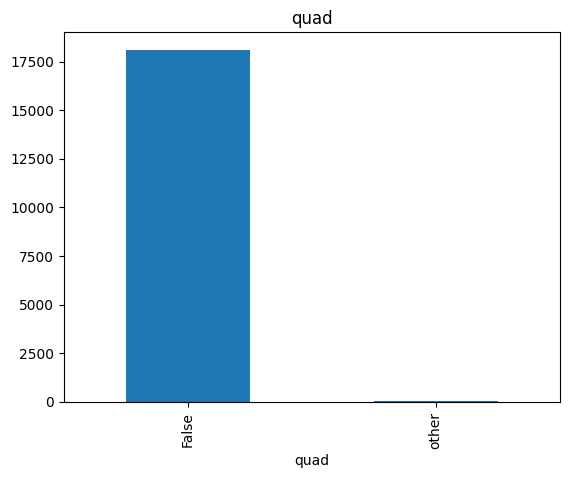

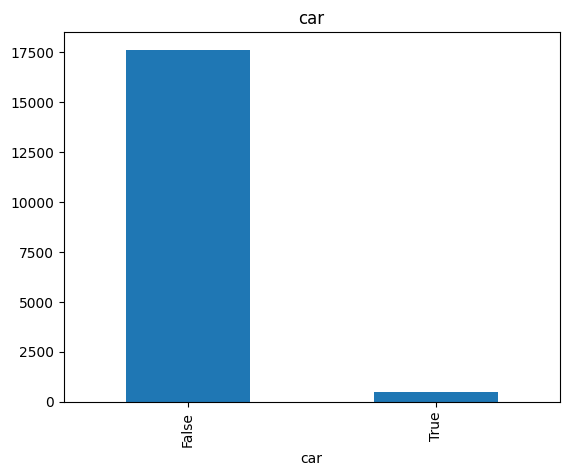

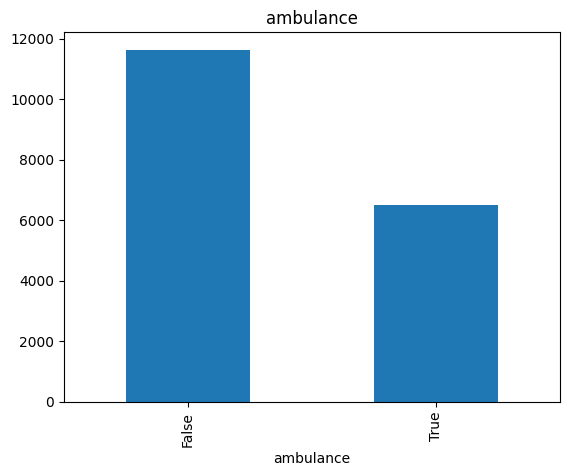

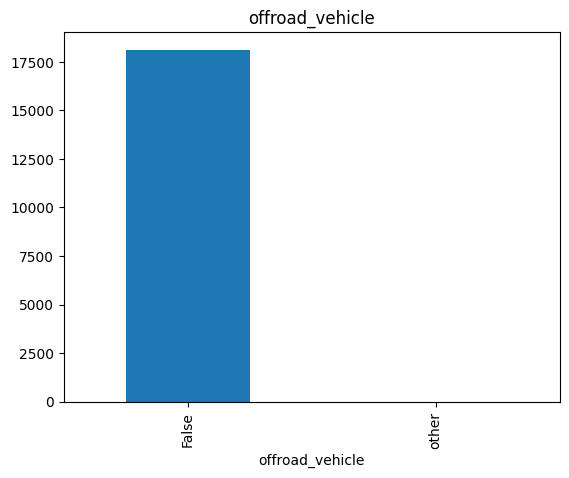

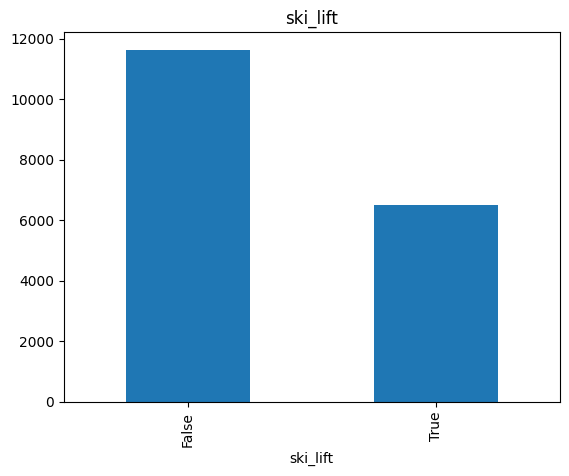

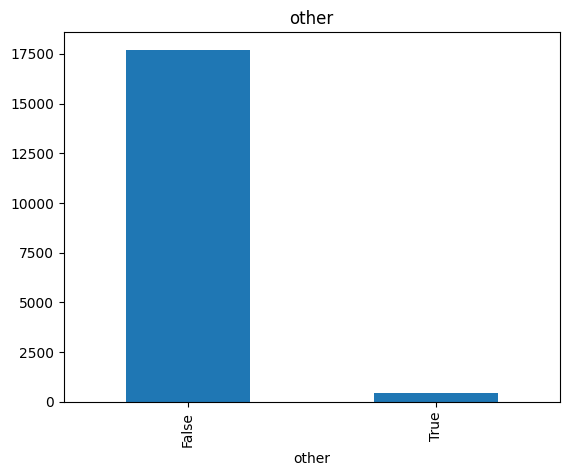

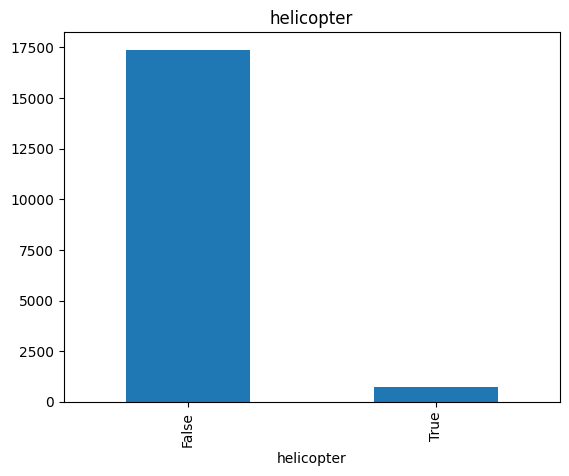

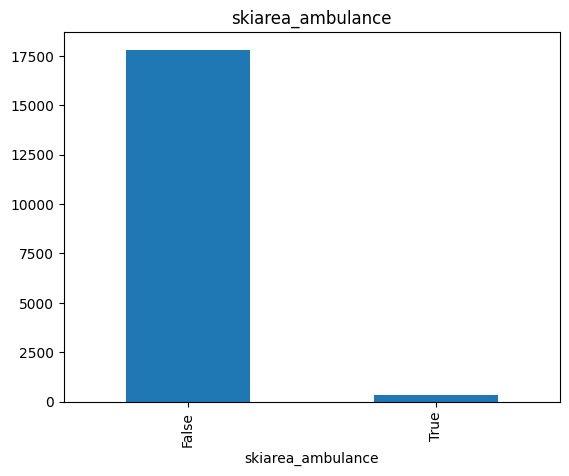

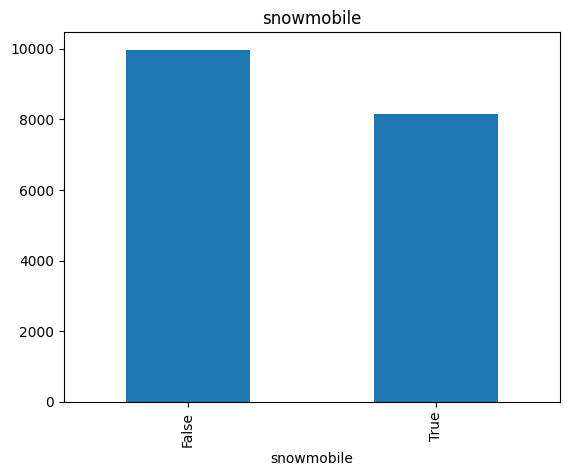

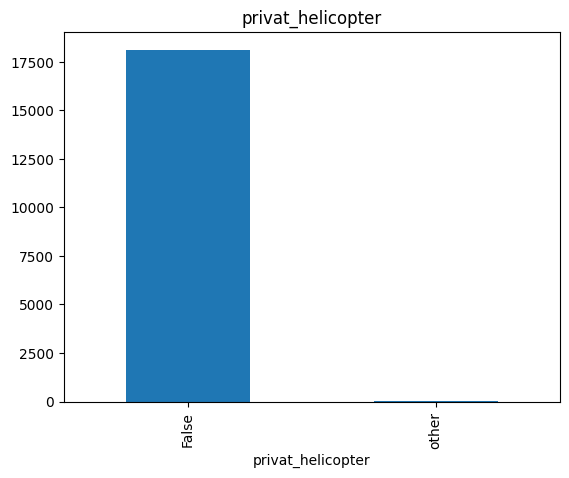

In [10]:
for c in labeled_small.columns:
    if c not in ['india','age']:
        plt.figure()
        labeled_small.groupby(c)[c].count().plot(kind='bar')
        plt.title(c)

    

In [11]:
X_train, X_test, y_train, y_test = train_test_split( labeled.drop(columns=['india']),
                                                    labeled.india, test_size=0.33, random_state=0,stratify=labeled.india)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split( labeled_small.drop(columns=['india']),
                                                    labeled_small.india, test_size=0.33, random_state=0,stratify=labeled_small.india)

In [12]:
assert (y_test_small!=y_test).sum()==0

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.33, random_state=0,stratify=y_train)
X_train_small, X_valid_small, y_train_small, y_valid_small = train_test_split(X_train_small,y_train_small, test_size=0.33, random_state=0,stratify=y_train_small)
assert (y_train!=y_train_small).sum()==0

In [14]:
w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
w.columns = ['class','p']
w.p = np.sqrt(w.p.sum())/w.p
print(w)
weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values


  class          p
0    i0   0.238038
1    i1   0.014605
2    i2   0.059746
3    i3   1.326712
4    i4  18.043281


In [15]:
##THIS IS BETTER
w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
w.columns = ['class','p']
w.p = w.p.sum()/w.p/w.shape[0]
print(w)
weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values
weight_train

  class          p
0    i0   4.294987
1    i1   0.263526
2    i2   1.078013
3    i3  23.938235
4    i4     325.56


array([0.26352598348712963, 0.26352598348712963, 0.26352598348712963, ...,
       0.26352598348712963, 0.26352598348712963, 0.26352598348712963],
      dtype=object)

In [14]:
#w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
#w.columns = ['class','p']
#w.p = np.sqrt(np.array((w.p.sum()/w.p).values).astype(float))
#print(w)
#weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values

/home/agobbi/miniconda3/envs/pid/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:

def objective(trial):#,X_train,y_train,X_valid,y_valid,weight_train):
    params = dict(
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10)

    
    dtrain = xgb.DMatrix(X_train,y_train.apply(lambda x:x.replace('i','')).astype(int), 
                         enable_categorical=True,
                         weight=weight_train)
    dvalid = xgb.DMatrix(X_valid,y_valid.apply(lambda x:x.replace('i','')).astype(int),
                         enable_categorical=True,
                         )


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=400,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds.argmax(1))    
    
    return mcc



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400, timeout=600)
params_final = dict(
            objective= 'multi:softprob', 
            nthread=4, 
             num_class= 5,
            seed=27)
params_final.update(study.best_params)
dtrain = xgb.DMatrix(X_train,y_train.apply(lambda x:x.replace('i','')).astype(int), 
                     enable_categorical=True,
                     weight=weight_train)
dvalid = xgb.DMatrix(X_valid,y_valid.apply(lambda x:x.replace('i','')).astype(int),
                     enable_categorical=True,
                     )   
bst = xgb.train(params_final, dtrain,verbose_eval=False, num_boost_round=400,
                evals = [(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=100,)


[I 2024-02-06 14:37:36,968] A new study created in memory with name: no-name-8b1bdfdd-e3cb-45db-9c0e-6eb1ae9b8446
[I 2024-02-06 14:37:37,530] Trial 0 finished with value: 0.41412437398662677 and parameters: {'learning_rate': 0.15853226702714224, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 4.729626369017826, 'subsample': 0.5426209375713748, 'colsample_bytree': 0.9703389471149142, 'alpha': 5.586954983474277, 'lambda': 9.3082424924606}. Best is trial 0 with value: 0.41412437398662677.
[I 2024-02-06 14:37:37,796] Trial 1 finished with value: 0.3960132364280116 and parameters: {'learning_rate': 0.16613146689992717, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 6.900506860723924, 'subsample': 0.5100114314446524, 'colsample_bytree': 0.950468769462696, 'alpha': 7.878260265301471, 'lambda': 5.5206531074325795}. Best is trial 0 with value: 0.41412437398662677.
[I 2024-02-06 14:37:38,314] Trial 2 finished with value: 0.39687281254752094 and parameters: {'learning_rate': 0.08479412076572246,

In [ ]:

def objective_small(trial):#,X_train,y_train,X_valid,y_valid,weight_train):
    params = dict(
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10)

    
    dtrain = xgb.DMatrix(X_train_small,y_train_small.apply(lambda x:x.replace('i','')).astype(int), 
                         enable_categorical=True,
                         weight=weight_train)
    dvalid = xgb.DMatrix(X_valid_small,y_valid_small.apply(lambda x:x.replace('i','')).astype(int),
                         enable_categorical=True,
                         )


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=400,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid_small.apply(lambda x:x.replace('i','')).astype(int),preds.argmax(1))    
    
    return mcc



study_small = optuna.create_study(direction="maximize")
study_small.optimize(objective_small, n_trials=400, timeout=600)
params_final = dict(
            objective= 'multi:softprob', 
            nthread=4, 
             num_class= 5,
            seed=27)
params_final.update(study_small.best_params)
dtrain_small = xgb.DMatrix(X_train_small,y_train_small.apply(lambda x:x.replace('i','')).astype(int), 
                     enable_categorical=True,
                     weight=weight_train)
dvalid_small = xgb.DMatrix(X_valid_small,y_valid_small.apply(lambda x:x.replace('i','')).astype(int),
                     enable_categorical=True,
                     )   
bst_small = xgb.train(params_final, dtrain_small,verbose_eval=False, num_boost_round=400,
                evals = [(dtrain_small, "train"), (dvalid_small, "valid")],
                early_stopping_rounds=100,)


[I 2024-02-08 08:49:27,816] A new study created in memory with name: no-name-2f227395-b778-4aaa-b296-1d0640474238
[I 2024-02-08 08:49:28,661] Trial 0 finished with value: 0.375796038397225 and parameters: {'learning_rate': 0.030801545039845647, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 7.746823493461809, 'subsample': 0.8234749751126704, 'colsample_bytree': 0.11185335931744318, 'alpha': 3.6100663490935494, 'lambda': 6.3115859791272655}. Best is trial 0 with value: 0.375796038397225.
[I 2024-02-08 08:49:29,278] Trial 1 finished with value: 0.40996246582648016 and parameters: {'learning_rate': 0.035067820664654865, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 4.267923278149038, 'subsample': 0.08083659979118042, 'colsample_bytree': 0.39374409585882136, 'alpha': 0.37017563988801294, 'lambda': 4.645896006641118}. Best is trial 1 with value: 0.40996246582648016.
[I 2024-02-08 08:49:30,002] Trial 2 finished with value: 0.38866482460937335 and parameters: {'learning_rate': 0.0222404476

Text(0, 0.5, 'Feature Importance Score')

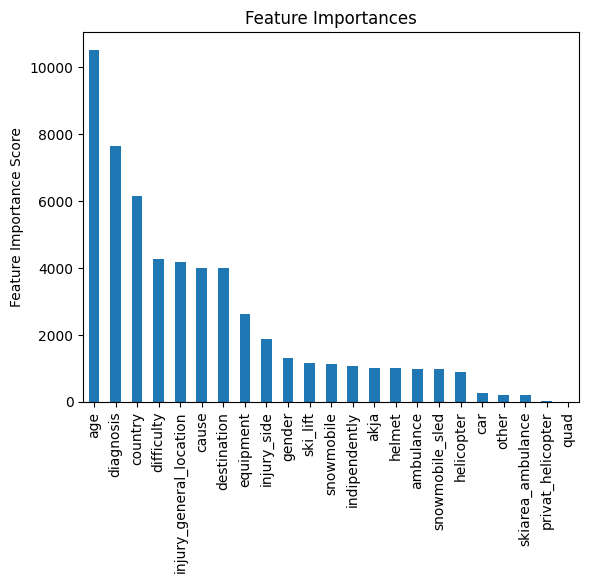

In [21]:
feat_imp = pd.Series(bst_small.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [22]:
preds_class_valid = bst.predict(dvalid)
preds_class_train= bst.predict(dtrain)
print(confusion_matrix(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(accuracy_score(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(accuracy_score(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))

[[ 142   43    2    0    0]
 [  58 2529  455    1    0]
 [   0  266  461   17    0]
 [   0    3   18   13    0]
 [   0    2    0    0    0]]
0.48560756020354895
0.78428927680798
########################################
[[ 379    0    0    0    0]
 [  74 5564  535    4    0]
 [   1   32 1476    1    0]
 [   0    0    0   68    0]
 [   0    0    0    0    5]]
0.8268686048760869
0.9205062046934512


In [23]:
preds_class_valid = bst_small.predict(dvalid_small)
preds_class_train= bst_small.predict(dtrain_small)
print(confusion_matrix(y_valid_small.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid_small.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(accuracy_score(y_valid_small.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train_small.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train_small.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(accuracy_score(y_train_small.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))

[[ 142   43    2    0    0]
 [  65 2482  494    2    0]
 [   2  231  484   27    0]
 [   0    3   18   13    0]
 [   0    2    0    0    0]]
0.4899696708847772
0.7783042394014963
########################################
[[ 379    0    0    0    0]
 [  96 5392  683    6    0]
 [   1   76 1432    1    0]
 [   0    0    0   68    0]
 [   0    0    0    0    5]]
0.7743830583167292
0.893967317852316


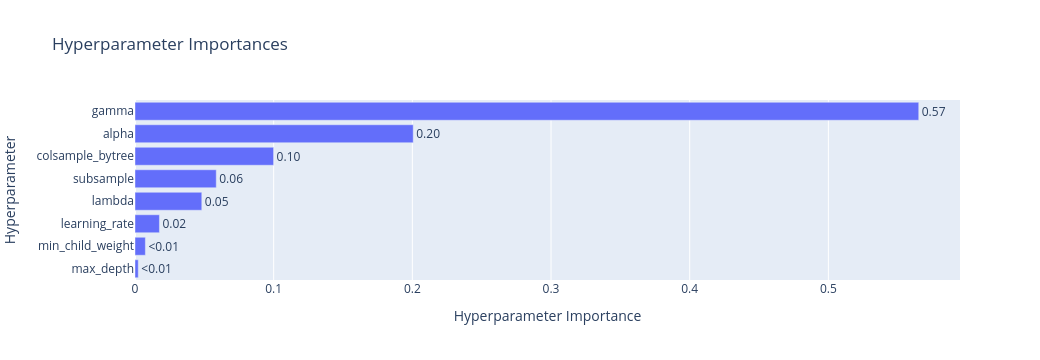

In [27]:
from optuna.visualization import plot_param_importances,plot_edf,plot_optimization_history
#plot_edf(study)
#plot_optimization_history(study)

plot_param_importances(study_small)

In [28]:
params_final

{'objective': 'multi:softprob',
 'nthread': 4,
 'num_class': 5,
 'seed': 27,
 'learning_rate': 0.05512860195007843,
 'max_depth': 7,
 'min_child_weight': 1,
 'gamma': 0.18858850578168745,
 'subsample': 0.6635246134540167,
 'colsample_bytree': 0.9300947822236749,
 'alpha': 0.2006663031138782,
 'lambda': 4.858042373367558}

[I 2024-02-06 15:45:34,987] A new study created in memory with name: no-name-13274e7d-fb35-4b87-8b4f-04cb66fe397e
[I 2024-02-06 15:45:36,050] Trial 0 finished with value: 0.4057089921074421 and parameters: {'gamma': 8.53351713182836, 'subsample': 0.9733024325557763, 'colsample_bytree': 0.7796967537918551, 'alpha': 0.23966291939500506, 'lambda': 7.588089377597536}. Best is trial 0 with value: 0.4057089921074421.
[I 2024-02-06 15:45:37,604] Trial 1 finished with value: 0.4611715187336915 and parameters: {'gamma': 0.02477032024294057, 'subsample': 0.6324878172866865, 'colsample_bytree': 0.6506407517812984, 'alpha': 2.8121200570991753, 'lambda': 4.209373703072621}. Best is trial 1 with value: 0.4611715187336915.
[I 2024-02-06 15:45:38,241] Trial 2 finished with value: 0.403681140412304 and parameters: {'gamma': 5.426488257981369, 'subsample': 0.596709754009448, 'colsample_bytree': 0.9033378255865846, 'alpha': 8.301806776056935, 'lambda': 8.01244058347282}. Best is trial 1 with value: 0.461

In [ ]:
### if you want to use shap you need to one-hot encoding all the categorical featues :-( 

In [219]:
def transform(x):
    labels = ['age']
    tmp = [np.array(x.age.values).reshape(-1,1)]
    for c in x.columns:
        if c!='age':
            values = x[c].cat.categories.values
            m = np.zeros((x.shape[0],len(values)))
            for i in range(x.shape[0]):
                idx = np.where(x[c].values[i]==x[c].cat.categories.values)[0][0]
                m[i,idx] = 1
            labels+=[f'{c}_{v}' for v in values]
            tmp.append( m )
    return pd.DataFrame(np.hstack(tmp),columns=labels)

In [220]:
X_train_oh = transform(X_train)
X_valid_oh = transform(X_valid)


In [285]:

def objective(trial):#,X_train,y_train,X_valid,y_valid,weight_train):
    params = dict(
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10)

    
    dtrain = xgb.DMatrix(X_train_oh,y_train.apply(lambda x:x.replace('i','')).astype(int), 
                         weight=weight_train)
    dvalid = xgb.DMatrix(X_valid_oh,y_valid.apply(lambda x:x.replace('i','')).astype(int),
                         )


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=400,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds.argmax(1))    
    
    return mcc



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400, timeout=600)



[I 2024-02-05 16:14:27,578] A new study created in memory with name: no-name-1915742c-6759-4e33-ab8e-13965e7fcb3d
[I 2024-02-05 16:14:28,230] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.0658738232703949, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 5.448972648984092, 'subsample': 0.04217710019453476, 'colsample_bytree': 0.8030593829858329, 'alpha': 4.734211939434967, 'lambda': 2.1883972022445164}. Best is trial 0 with value: 0.0.
[I 2024-02-05 16:14:29,107] Trial 1 finished with value: 0.31912965831163864 and parameters: {'learning_rate': 0.04746325622117008, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 4.647214261820661, 'subsample': 0.7833462910828093, 'colsample_bytree': 0.22586498890152337, 'alpha': 6.791756742408147, 'lambda': 0.7955658916862274}. Best is trial 1 with value: 0.31912965831163864.
[I 2024-02-05 16:14:30,188] Trial 2 finished with value: 0.3462484882869544 and parameters: {'learning_rate': 0.05001069509508385, 'max_depth': 10, 'min_chil

In [286]:
params_final = dict(
            objective= 'multi:softprob', 
            nthread=4, 
             num_class= 5,
            seed=27)
params_final.update(study_small.best_params)




dtrain = xgb.DMatrix(X_train_small,y_train_small.apply(lambda x:x.replace('i','')).astype(int), 
                    
                     weight=weight_train)
dvalid = xgb.DMatrix(X_valid_small,y_valid_small.apply(lambda x:x.replace('i','')).astype(int),
                   
                     )



    
bst = xgb.train(params_final, dtrain,verbose_eval=False, num_boost_round=1000,
                evals = [(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=100,)

In [287]:
preds_class_valid = bst.predict(dvalid)
preds_class_train= bst.predict(dtrain)
print(confusion_matrix(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(accuracy_score(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(accuracy_score(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))

[[ 158   26    2    1    0]
 [ 236 2056  731   19    1]
 [   4  159  494   85    2]
 [   1    1   13   18    1]
 [   1    0    0    0    1]]
0.4078378215401631
0.6800498753117207
########################################
[[ 350   23    4    2    0]
 [ 477 4252 1416   32    0]
 [  13  268 1090  134    5]
 [   0    0    0   68    0]
 [   0    0    0    0    5]]
0.46853573039294066
0.7083179751812262


In [271]:
import shap
explainer = shap.TreeExplainer(bst,feature_names=X_valid_oh.columns)

explanation = explainer(dvalid)

shap_values = explanation
print(shap_values.values.shape)

(4010, 184, 5)


In [284]:
X_train_oh.loc[0][X_train_oh.columns[np.argsort(-shap_values.values[0,:,1],)][0:20]]

diagnosis_muscular_sprain               0.0
'ski_lift'_False                        0.0
age                                    15.0
injury_general_location_lower_limbs     1.0
'ski_lift'_True                         1.0
gender_M                                0.0
diagnosis_fracture                      0.0
injury_side_None                        0.0
'helicopter'_True                       0.0
difficulty_easy                         1.0
'ambulance'_False                       1.0
'helicopter'_False                      1.0
gender_F                                1.0
destination_hospital_emergency_room     0.0
injury_side_L                           1.0
injury_general_location_None            0.0
'ambulance'_True                        0.0
country_Germania                        1.0
injury_general_location_trunk           0.0
diagnosis_None                          0.0
Name: 0, dtype: float64

In [280]:
X_train_oh.columns[np.argsort(-shap_values.values[0,:,1],)][0:10]

Index(['diagnosis_muscular_sprain', ''ski_lift'_False', 'age',
       'injury_general_location_lower_limbs', ''ski_lift'_True', 'gender_M',
       'diagnosis_fracture', 'injury_side_None', ''helicopter'_True',
       'difficulty_easy'],
      dtype='object')

Glyph 9 (	) missing from current font.


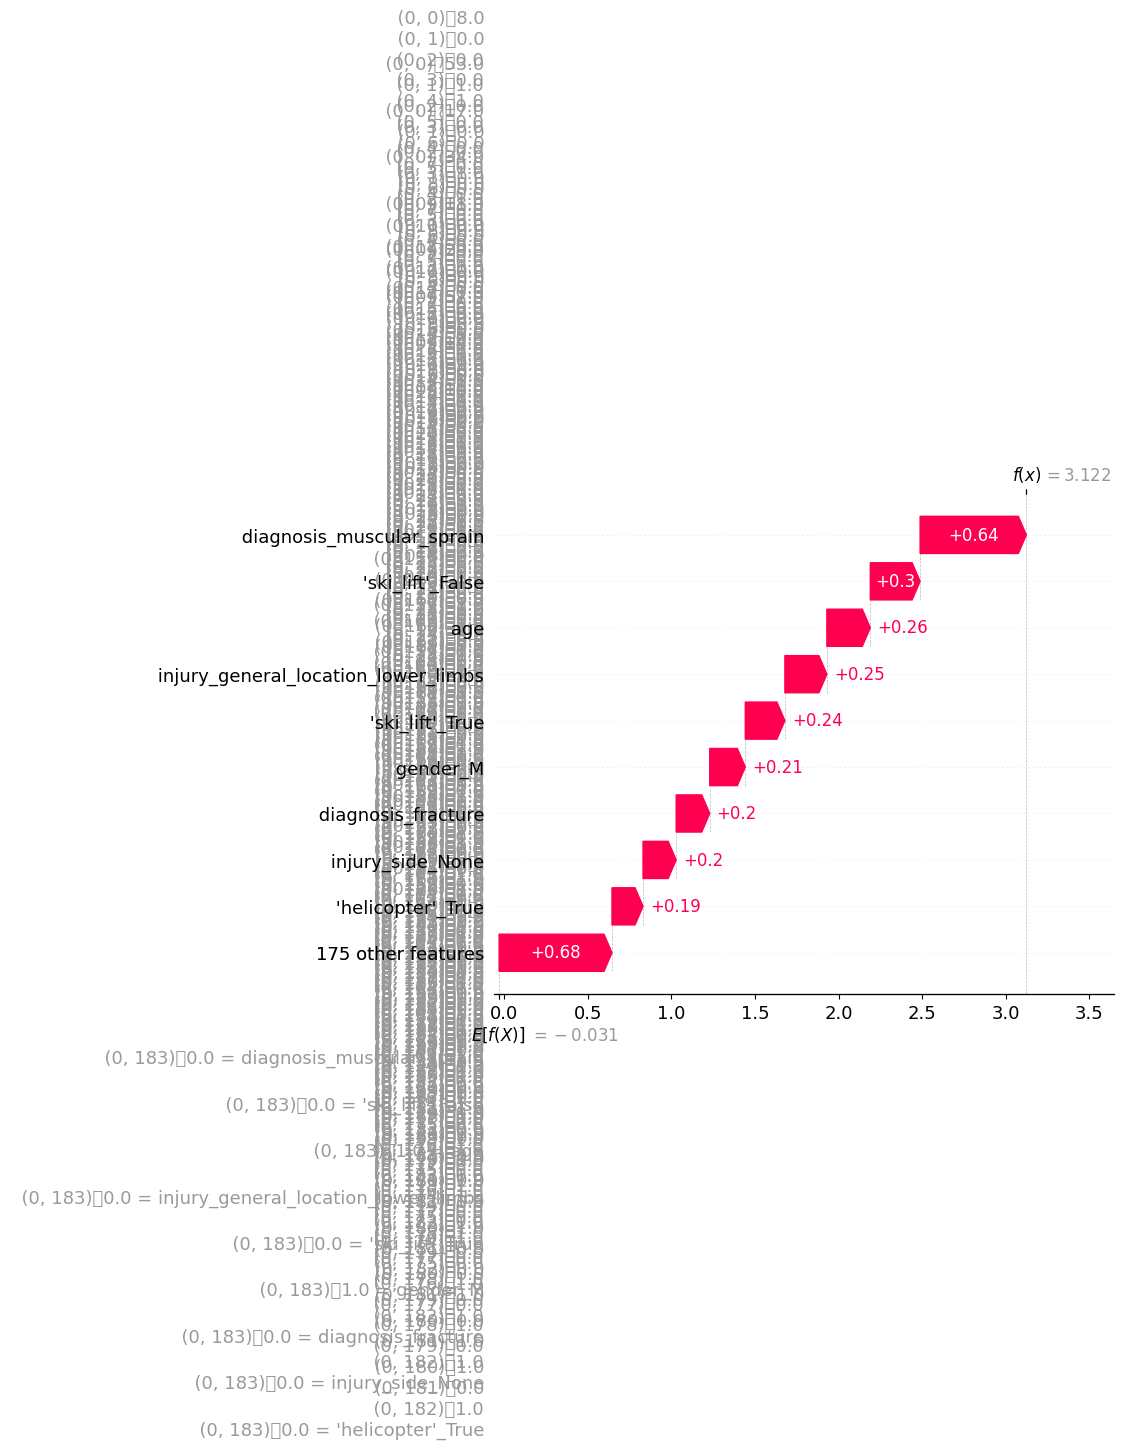

In [276]:
shap.plots.waterfall(shap_values[0,:,1])